#### Exile on Online Opposition

Examine the effect of exile on percentage of tweets' harsh criticism of Venezuela government.

ESBERG, J., & SIEGEL, A. (2023). How Exile Shapes Online Opposition: Evidence from Venezuela. American Political Science Review, 117(4), 1361-1378.

In [1]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from matplotlib import pyplot as plt
from gpytorch.means import ZeroMean, LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

we first implement GPR for right panel of figure 4.

In [2]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_harsh_criticism", "lead_lags","month","num_tweets", "exile", "date_of_exile", "actor.id"]]
data = data[~data.lead_lags.isna()]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, dummies for lead_lags
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    pd.get_dummies(data['lead_lags']).values))).double()

ys = torch.tensor(data.perc_harsh_criticism.values).double()

we build a Gaussian process regression model with a linear mean function and an automatic relevance determination RBF kernel:
$$
f(t,D) \sim\mathcal{GP}(\beta x,K)
$$

In [65]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class ConstantVectorMean(Mean):
    def __init__(self, n, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, n)))
    
    def forward(self, input):
        return self.constantvector[input.long()]

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        # self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x = self.covar_module(x[:,2:]) # + self.t_covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [68]:
from torch.utils.data import TensorDataset, DataLoader

inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# initialize model parameters
# model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
# model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.01
# model.t_covar_module.raw_outputscale.require_grad = False
# model.t_covar_module.outputscale = 1.
model.covar_module.raw_outputscale.requires_grad = False
model.covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {\
                #     model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                # model.t_covar_module.raw_outputscale,\
                \
                model.covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.1)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 20
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 2000:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


Epoch 1 Iter 2 - Loss: 180.029
Epoch 1 Iter 3 - Loss: 136.734
Epoch 1 Iter 4 - Loss: 139.053
Epoch 1 Iter 5 - Loss: 126.825
Epoch 1 Iter 6 - Loss: 114.277
Epoch 1 Iter 7 - Loss: 111.970
Epoch 1 Iter 8 - Loss: 87.447
Epoch 1 Iter 9 - Loss: 67.979
Epoch 1 Iter 10 - Loss: 77.062
Epoch 1 Iter 11 - Loss: 58.602
Epoch 1 Iter 12 - Loss: 84.486
Epoch 1 Iter 13 - Loss: 70.617
Epoch 1 Iter 14 - Loss: 74.991
Epoch 1 Iter 15 - Loss: 73.096
Epoch 1 Iter 16 - Loss: 46.800
Epoch 1 Iter 17 - Loss: 57.567
Epoch 1 Iter 18 - Loss: 51.942
Epoch 1 Iter 19 - Loss: 46.602
Epoch 1 Iter 20 - Loss: 54.956
Epoch 1 Iter 21 - Loss: 59.328
Epoch 1 Iter 22 - Loss: 44.144
Epoch 1 Iter 23 - Loss: 51.195
Epoch 1 Iter 24 - Loss: 40.872
Epoch 1 Iter 25 - Loss: 40.873
Epoch 1 Iter 26 - Loss: 47.213
Epoch 1 Iter 27 - Loss: 57.237
Epoch 1 Iter 28 - Loss: 40.318
Epoch 1 Iter 29 - Loss: 38.865
Epoch 1 Iter 30 - Loss: 47.797
Epoch 1 Iter 31 - Loss: 40.868
Epoch 1 Iter 32 - Loss: 43.676
Epoch 1 Iter 33 - Loss: 34.851
Epoch 1 It

In [15]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [69]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [74]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + \
                  sampled_dydtest_x.std(1).mean(0)**2).round(decimals=5)
covariate_names = ["time","log_num_tweets"]
# for tmp in pd.get_dummies(data['lead_lags']).columns.tolist():
#     covariate_names.append("beta "+tmp)
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:],
                        'est_std': est_std[1:]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

ValueError: arrays must all be same length

IndexError: index 0 is out of bounds for axis 0 with size 0

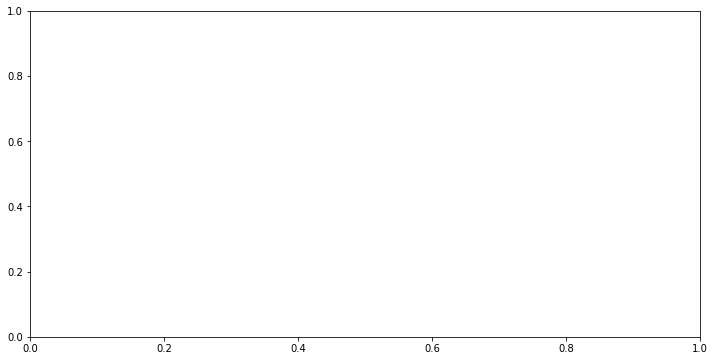

In [71]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_est_mean = []
plot_est_std = []
for i in range(-6,12):
    if i==-7:
        plot_est_mean.append(results[results.x==("beta pre")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta pre")].est_std.values[0])
    elif i==12:
        plot_est_mean.append(results[results.x==("beta post")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta post")].est_std.values[0])
    elif i==-1:
        plot_est_mean.append(results[results.x==("beta month_before")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta month_before")].est_std.values[0])
    else:
        plot_est_mean.append(results[results.x==("beta "+str(i))].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta "+str(i))].est_std.values[0])
ax.errorbar([i  for i in range(-6,12)], np.array(plot_est_mean)-plot_est_mean[5], yerr=plot_est_std, fmt="k", ecolor="k")
ax.axvline(x=-0.5, ls="--", color="gray")
ax.axhline(y=0, ls="--", color="gray")
ax.set_xlabel("Months Since Exile")
ax.set_ylabel("Change in % Tweets on Harsh Criticism")
ax.set_xticks(range(-5,10,5))
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')

next we estimate effect of exile on percentage of harsh criticism for left panel of figure 4.

In [48]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_harsh_criticism", "exile", "month","num_tweets", "date_of_exile", "actor.id"]]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, exile
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    data['exile'].values.reshape((-1,1))=="yes")))
ys = torch.tensor(data.perc_harsh_criticism.values).double()

In [30]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1,2]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x =  self.t_covar_module(x) # self.covar_module(x[:,2:]) +
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [31]:
inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.1)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 20
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 200:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


Epoch 1 Iter 2 - Loss: 178.160
Epoch 1 Iter 3 - Loss: 171.044
Epoch 1 Iter 4 - Loss: 174.585
Epoch 1 Iter 5 - Loss: 155.254
Epoch 1 Iter 6 - Loss: 109.192
Epoch 1 Iter 7 - Loss: 121.211
Epoch 1 Iter 8 - Loss: 106.765
Epoch 1 Iter 9 - Loss: 101.079
Epoch 1 Iter 10 - Loss: 97.810
Epoch 1 Iter 11 - Loss: 96.693
Epoch 1 Iter 12 - Loss: 100.591
Epoch 1 Iter 13 - Loss: 91.283
Epoch 1 Iter 14 - Loss: 87.534
Epoch 1 Iter 15 - Loss: 76.135
Epoch 1 Iter 16 - Loss: 69.843
Epoch 1 Iter 17 - Loss: 68.789
Epoch 1 Iter 18 - Loss: 68.475
Epoch 1 Iter 19 - Loss: 55.780
Epoch 1 Iter 20 - Loss: 57.528
Epoch 1 Iter 21 - Loss: 55.917
Epoch 1 Iter 22 - Loss: 46.741
Epoch 1 Iter 23 - Loss: 53.282
Epoch 2 Iter 2 - Loss: 49.578
Epoch 2 Iter 3 - Loss: 52.003
Epoch 2 Iter 4 - Loss: 43.781
Epoch 2 Iter 5 - Loss: 42.412
Epoch 2 Iter 6 - Loss: 47.993
Epoch 2 Iter 7 - Loss: 40.478
Epoch 2 Iter 8 - Loss: 46.655
Epoch 2 Iter 9 - Loss: 41.822
Epoch 2 Iter 10 - Loss: 42.503
Epoch 2 Iter 11 - Loss: 42.345
Epoch 2 Iter 12

In [32]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [33]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [37]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + \
                  sampled_dydtest_x.std(1).mean(0)**2).round(decimals=5)

covariate_names = ["log_num_tweets"]
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[2:3],
                        'est_std': est_std[2:3]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                x  est_mean  est_std          t  pvalue
0  log_num_tweets  2.577454  0.03093  83.331845     0.0


In [38]:
model.eval()
likelihood.eval()

# copy training tesnor to test tensors and set exile to 1 and 0
test_x1 = xs.clone().detach().requires_grad_(False)
test_x1[:,3] = 1
test_x0 = xs.clone().detach().requires_grad_(False)
test_x0[:,3] = 0

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out1 = likelihood(model(test_x1))
    out0 = likelihood(model(test_x0))

# compute ATE and its uncertainty
effect = out1.mean.numpy().mean() - out0.mean.numpy().mean()
effect_std = np.sqrt((out1.mean.numpy().mean()+out0.mean.numpy().mean())) / np.sqrt(xs.size()[0])
BIC = (1+1+2+1)*\
    torch.log(torch.tensor(xs.size()[0])) + 2*loss*xs.size(0)/1024
print("ATE: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*xs.size(0)/1024))
print("BIC: {:0.3f} \n".format(BIC))

ATE: 6.359 +- 0.036

model evidence: -138.928 

BIC: 328.000 



In [4]:
import statsmodels.formula.api as sm

# monthly fixed effect
data["log_num_tweets"] = np.log(data["num_tweets"])
data["t"] = xs[:,1].numpy()
lm = sm.ols('perc_harsh_criticism ~ 1 + log_num_tweets + exile + C(t)', data).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     perc_harsh_criticism   R-squared:                       0.209
Model:                              OLS   Adj. R-squared:                  0.206
Method:                   Least Squares   F-statistic:                     66.28
Date:                  Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                          14:35:18   Log-Likelihood:                -90566.
No. Observations:                 22609   AIC:                         1.813e+05
Df Residuals:                     22518   BIC:                         1.820e+05
Df Model:                            90                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.496

In [5]:
# two-way fixed effect
data["actor_id"] = data["actor.id"]
lm = sm.ols('perc_harsh_criticism ~ 1 + log_num_tweets + exile + C(t) + C(actor_id)', data).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     perc_harsh_criticism   R-squared:                       0.478
Model:                              OLS   Adj. R-squared:                  0.467
Method:                   Least Squares   F-statistic:                     45.59
Date:                  Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                          14:35:25   Log-Likelihood:                -85875.
No. Observations:                 22609   AIC:                         1.726e+05
Df Residuals:                     22163   BIC:                         1.762e+05
Df Model:                           445                                         
Covariance Type:              nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [10]:
# time trend
lm = sm.ols('perc_harsh_criticism ~  log_num_tweets + exile + C(t)  + t:C(actor_id)', data).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     perc_harsh_criticism   R-squared:                       0.502
Model:                              OLS   Adj. R-squared:                  0.492
Method:                   Least Squares   F-statistic:                     50.19
Date:                  Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                          14:36:33   Log-Likelihood:                -85330.
No. Observations:                 22609   AIC:                         1.716e+05
Df Residuals:                     22162   BIC:                         1.751e+05
Df Model:                           446                                         
Covariance Type:              nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------